In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats                      
from iminuit import Minuit
from iminuit.cost import LeastSquares
from itertools import accumulate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd

In [2]:
t_HLA = np.load('times_HLA.npy')
t_DAZ = np.load('times_DAZ.npy')
t_LWN = np.load('times_LWN.npy')
t_PVX = np.load('times_PVX.npy')

t1 = t_HLA
t2 = (t_DAZ[:-1] + t_DAZ[1:])[::2]
t3 = (t_LWN[:-2] + t_LWN[1:-1] + t_LWN[2:])[::3]
t4 = (t_PVX[:-2] + t_PVX[1:-1] + t_PVX[2:])[::3]
print(len(t1-2))
print(len(t2-2))
print(len(t3-2))
print(len(t4-2))

t1_sum = np.cumsum(t1)
t2_sum = np.cumsum(t2)
t3_sum = np.cumsum(t3)
t4_sum = np.cumsum(t4)

t1_mean = np.mean(t1)
t2_mean = np.mean(t2)
t3_mean = np.mean(t3)
t4_mean = np.mean(t4)

t1_std = np.std(t1)
t2_std = np.std(t2)
t3_std = np.std(t3)
t4_std = np.std(t4)

min_valuse = min(len(t1), len(t2), len(t3), len(t4))

all_times = np.zeros((4, min_valuse))
all_times[0, :] = t1[:min_valuse]
all_times[1, :] = t2[:min_valuse]
all_times[2, :] = t3[:min_valuse]
all_times[3, :] = t4[:min_valuse]
times = np.mean(all_times, axis=0)
times_sum = np.cumsum(times)

long_list = np.concatenate((t1,t2,t3,t4))
long_list_sum = np.cumsum(long_list)

np.random.shuffle(long_list)

long_list_scramble_sum = np.cumsum(long_list)
print(long_list_scramble_sum)

print(34 / 36)
print(36 / 38)
print(22 / 24)
print(48 / 50)

36
38
24
50
[   9.39003897   18.95202589   28.35058379   37.76003575   47.151057
   56.60034394   66.25107789   75.96283317   85.50701094   95.25095797
  104.44411492  113.880656    122.99165702  132.4650619   141.87302399
  151.26137829  160.49524331  170.06382322  179.3581965   188.84486222
  198.23981118  207.41878176  216.52680659  225.42259574  234.80069065
  244.03576255  253.38596845  262.78102112  272.41215205  281.7397356
  291.33230424  300.73449969  310.08460069  319.50520396  328.6821208
  338.15343642  347.66337442  356.99472475  366.5520463   375.80712247
  385.41765642  394.54532242  403.65406466  413.00191355  422.29960632
  431.69104099  440.75866795  450.21066475  459.48827744  468.81411505
  478.0491333   487.47819233  496.60273743  505.89378452  515.33974767
  525.15743256  534.42393351  543.82342243  553.1991837   562.49280787
  572.32901692  581.63968205  591.22107673  600.81722569  610.55553174
  619.91175866  629.33260751  639.07929468  648.12691259  657.7493054

In [3]:
save_plots = False
Minuit.print_level = 0

#Uncertaintees
a = 9.82
b = 0
print(np.std(t4))
sigmay = 0.207

x_lin = np.arange(len(t4_sum))+1
y_lin = np.array(t4_sum) 
sy = sigmay*np.ones_like(x_lin)

def fit_func(x, a, b): 
    return a*x + b

chi2 = LeastSquares(x_lin,y_lin,sy,fit_func)

def chi2_func(a,b):
    return np.sum(((y_lin - fit_func(x_lin,a,b)) / sy)**2)

mfit = Minuit(chi2_func,a=a,b=b)

mfit.migrad();

a_fit = mfit.values['a']
b_fit = mfit.values['b']
sigma_a_fit = mfit.errors['a']
sigma_b_fit = mfit.errors['b']

Nvar = 2                     
Ndof_fit = len(t4) - Nvar

Chi2_fit = mfit.fval                            
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)



print(f"  Fit: a={a_fit:6.3f}+-{sigma_a_fit:5.3f}  b={b_fit:5.3f}+-{sigma_b_fit:5.3f}  p={Prob_fit:6.4f}")



0.20687864633016115
  Fit: a= 9.401+-0.002  b=-0.296+-0.059  p=0.9730


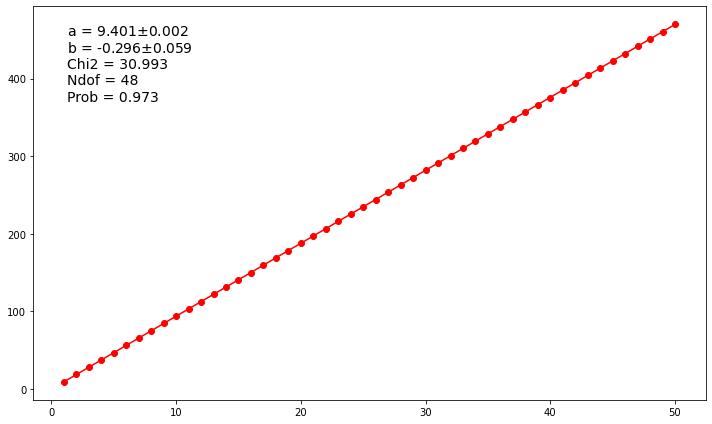

In [4]:
fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(x_lin, y_lin, sy, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
ax.plot(x_lin, fit_func(x_lin, *mfit.values[:]), '-r')

fit_info = [f'a = {a_fit:5.3f}' + r'$\pm$' +  f"{sigma_a_fit:5.3f}",
            f'b = {b_fit:5.3f}' + r'$\pm$' + f"{sigma_b_fit:5.3f}",
            f'Chi2 = {Chi2_fit:5.3f}',
            f'Ndof = {Ndof_fit:d}',
            f'Prob = {Prob_fit:5.3f}',
]
ax.text(0.05, 0.76, "\n".join(fit_info), fontsize=14, transform = ax.transAxes)
fig.tight_layout()


0.20702104176860314


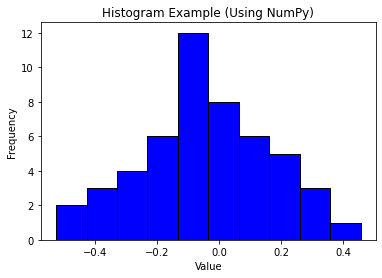

In [5]:
residuals = (a_fit - t4)

def RMS_res(data):
    RMS = np.sqrt(np.sum(np.square(data)) / len(data))
    return RMS
RMS = RMS_res(residuals)
print(RMS)


counts, bin_edges = np.histogram(residuals, bins=10)

# Plot the histogram
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), color='blue', edgecolor='black')

# Add titles and labels
plt.title('Histogram Example (Using NumPy)')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

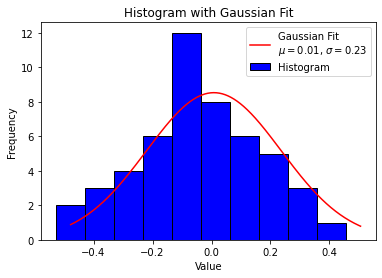

Fitted standard deviation (sigma): 0.23


In [6]:
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1]) 

def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

least_squares = LeastSquares(bin_centers, counts, np.sqrt(counts), gaussian)


m = Minuit(least_squares, A=max(counts), mu=np.mean(residuals), sigma=np.std(residuals))
m.migrad()  

A_fit, mu_fit, sigma_fit = m.values["A"], m.values["mu"], m.values["sigma"]

x_fit = np.linspace(bin_edges[0], bin_edges[-1], 500)
y_fit = gaussian(x_fit, A_fit, mu_fit, sigma_fit)

plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), color='blue', edgecolor='black', label="Histogram")
plt.plot(x_fit, y_fit, color="red", label=f"Gaussian Fit\n$\mu={mu_fit:.2f}$, $\sigma={sigma_fit:.2f}$")
plt.title("Histogram with Gaussian Fit")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Fitted standard deviation (sigma): {sigma_fit:.2f}")


No handles with labels found to put in legend.


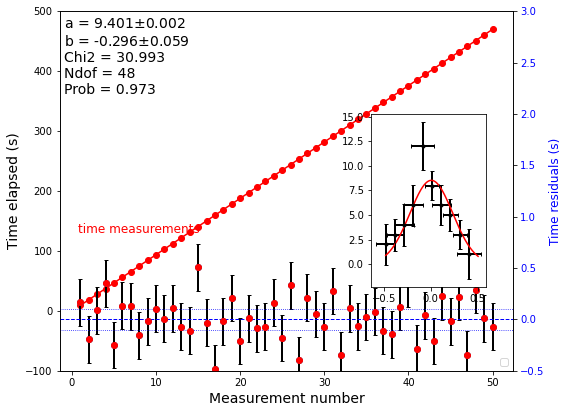

In [7]:
from matplotlib.transforms import Bbox
fig, ax_main = plt.subplots(figsize=(8, 6))

ax_main.errorbar(x_lin, y_lin, sy, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
ax_main.plot(x_lin, fit_func(x_lin, *mfit.values[:]), '-r')

ax_main.set_ylim(-100, 500)
ax_secondary = ax_main.twinx()

ax_secondary.errorbar(x_lin,residuals, sigma_fit, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
ax_secondary.scatter(x_lin,residuals)
ax_secondary.axhline(0, color='blue', linestyle='--', linewidth=1)
ax_secondary.axhline(0.1, color='blue', linestyle=':', linewidth=0.8)
ax_secondary.axhline(-0.1, color='blue', linestyle=':', linewidth=0.8)
ax_secondary.set_ylabel('Time residuals (s)', fontsize=12, color='blue')
ax_secondary.tick_params(axis='y', labelcolor='blue')
ax_secondary.set_ylim(-0.5, 3)
ax_secondary.legend(loc='lower right', fontsize=10)
fit_info = [f'a = {a_fit:5.3f}' + r'$\pm$' +  f"{sigma_a_fit:5.3f}",
            f'b = {b_fit:5.3f}' + r'$\pm$' + f"{sigma_b_fit:5.3f}",
            f'Chi2 = {Chi2_fit:5.3f}',
            f'Ndof = {Ndof_fit:d}',
            f'Prob = {Prob_fit:5.3f}',
]
ax_main.set_xlabel("Measurement number", fontsize=14)
ax_main.set_ylabel("Time elapsed (s)", fontsize=14)
x_text = x_lin[11]-4  # For example, place it near the middle of the x range
y_text = fit_func(x_text, *mfit.values[:]) + 50 # Compute the corresponding y value on the fit line

# Add the text to the plot
ax_main.text(x_text,y_text, "time measurements", fontsize=12, color='red',
             ha='center', va='bottom', rotation=0)
ax_main.text(0.04, 0.74, "\n".join(fit_info), fontsize=14, transform = ax.transAxes)
fig.tight_layout()


# Create the inset axis
inset_ax = fig.add_axes([0.65, 0.3, 0.2, 0.4])  # [left, bottom, width, height] in figure coordinates
# inset_ax.scatter(bin_edges[:-1], counts)
inset_ax.plot(x_fit, y_fit, color="red", label=f"Gaussian Fit\n$\mu={mu_fit:.2f}$, $\sigma={sigma_fit:.2f}$")
errors = np.random.normal(0.1, 0.02, len(counts))
inset_ax.errorbar(bin_edges[:-1], counts, 20*errors , errors, fmt='.', color ="k",ecolor='k', elinewidth=2, capsize=2, capthick=1)
fig.savefig("t44.pdf", format="pdf", bbox_inches="tight")

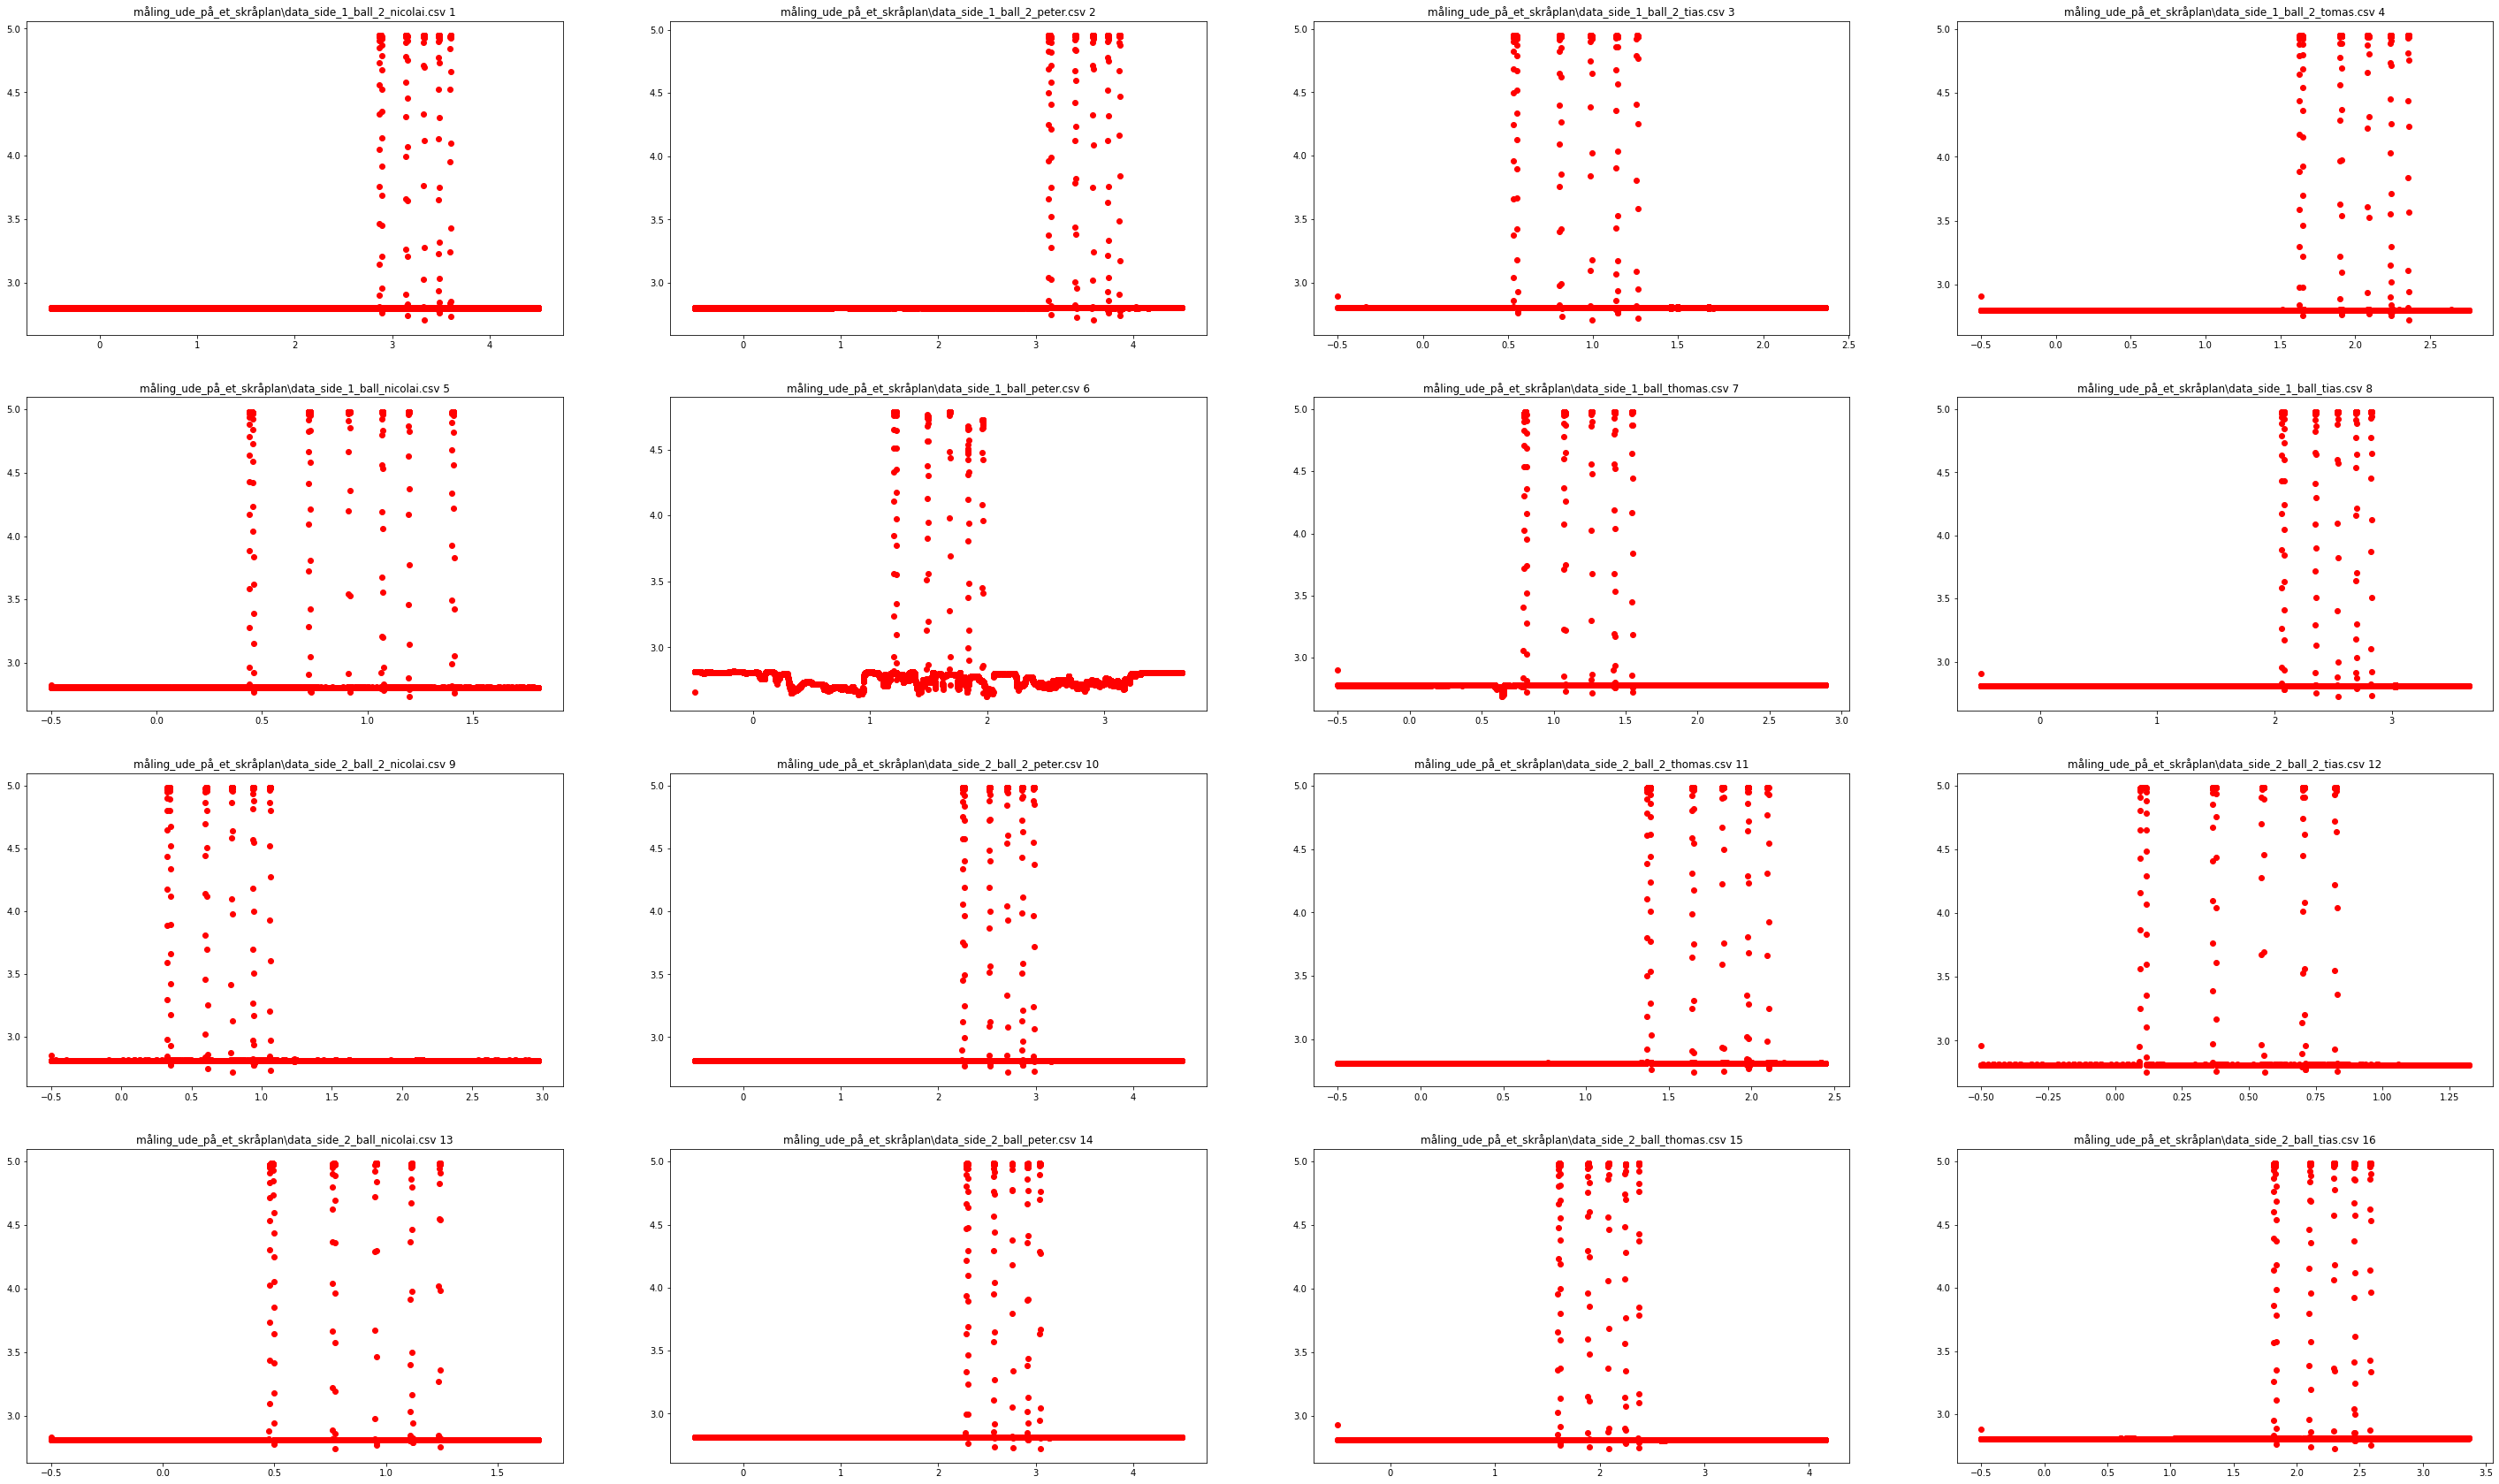

In [8]:
import glob as gb

files = gb.glob('måling_ude_på_et_skråplan/*.csv')


data_points  = []
for i, file in enumerate(files):
   data_points.append(np.genfromtxt(file, delimiter=',', skip_header=15, usecols=(0,1)))
   


fig, axs = plt.subplots(4,4,figsize=(50,30))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(data_points[i][:,0], data_points[i][:,1], 'ro')
    ax.set_title(f'{files[i]} {i+1}')


In [9]:
sensor_afstand_1 = np.array([18.6,36.4,54.5,73.6,91.2]) / 100
sensor_afstand_2 = np.array([18.7,36.3,54.6,73.5,91.2]) / 100
sensor_afstand_3 = np.array([18.7,36.4,54.6,73.55,91.65]) / 100
sensor_afstand_4 = np.array([18.4,36.4,54.5,73.5,91.2]) / 100
samlet_afstand = (sensor_afstand_1 + sensor_afstand_2 + sensor_afstand_3 + sensor_afstand_4) / 4 

d_r_inder = 0.006 
bold_1 = 0.01
bold_2 = 0.0125
vinkel_v = (76.1 + 76.5 + 76.1 + 76.2) / 4
vinkel_h = (76 + 76.3 + 75.95 + 75.9) / 4 
vinkel_v1 = (76.4 + 76.5 + 76.2 + 76.3) / 4
vinkel_h1 = (75.9 + 76.5 + 76 + 76) / 4
samlet_vinkel = (vinkel_v + vinkel_h + vinkel_v1 + vinkel_h1) / 4



fit: a= 0.763+-0.048  b=0.443+-0.037  c=0.181+-0.006  p=0.9673
fit: a= 0.764+-0.047  b=0.448+-0.036  c=0.181+-0.006  p=0.9711
fit: a= 0.764+-0.047  b=0.447+-0.036  c=0.181+-0.006  p=0.9673
fit: a= 0.763+-0.048  b=0.445+-0.037  c=0.181+-0.006  p=0.9619
fit: a= 0.699+-0.032  b=0.436+-0.026  c=0.182+-0.004  p=0.9806
fit: a= 0.702+-0.037  b=0.430+-0.029  c=0.182+-0.005  p=0.9746
fit: a= 0.694+-0.035  b=0.442+-0.028  c=0.182+-0.005  p=0.9876
fit: a= 0.692+-0.035  b=0.434+-0.028  c=0.182+-0.005  p=0.9892
fit: a= 0.754+-0.048  b=0.438+-0.037  c=0.181+-0.006  p=0.9676
fit: a= 0.750+-0.047  b=0.443+-0.037  c=0.181+-0.006  p=0.9616
fit: a= 0.757+-0.047  b=0.445+-0.036  c=0.181+-0.006  p=0.9682
fit: a= 0.756+-0.047  b=0.446+-0.036  c=0.181+-0.006  p=0.9546
fit: a= 0.693+-0.035  b=0.431+-0.028  c=0.182+-0.005  p=0.9810
fit: a= 0.694+-0.035  b=0.435+-0.028  c=0.182+-0.005  p=0.9866
fit: a= 0.674+-0.035  b=0.426+-0.028  c=0.182+-0.005  p=0.9126
fit: a= 0.684+-0.035  b=0.428+-0.028  c=0.182+-0.005  p

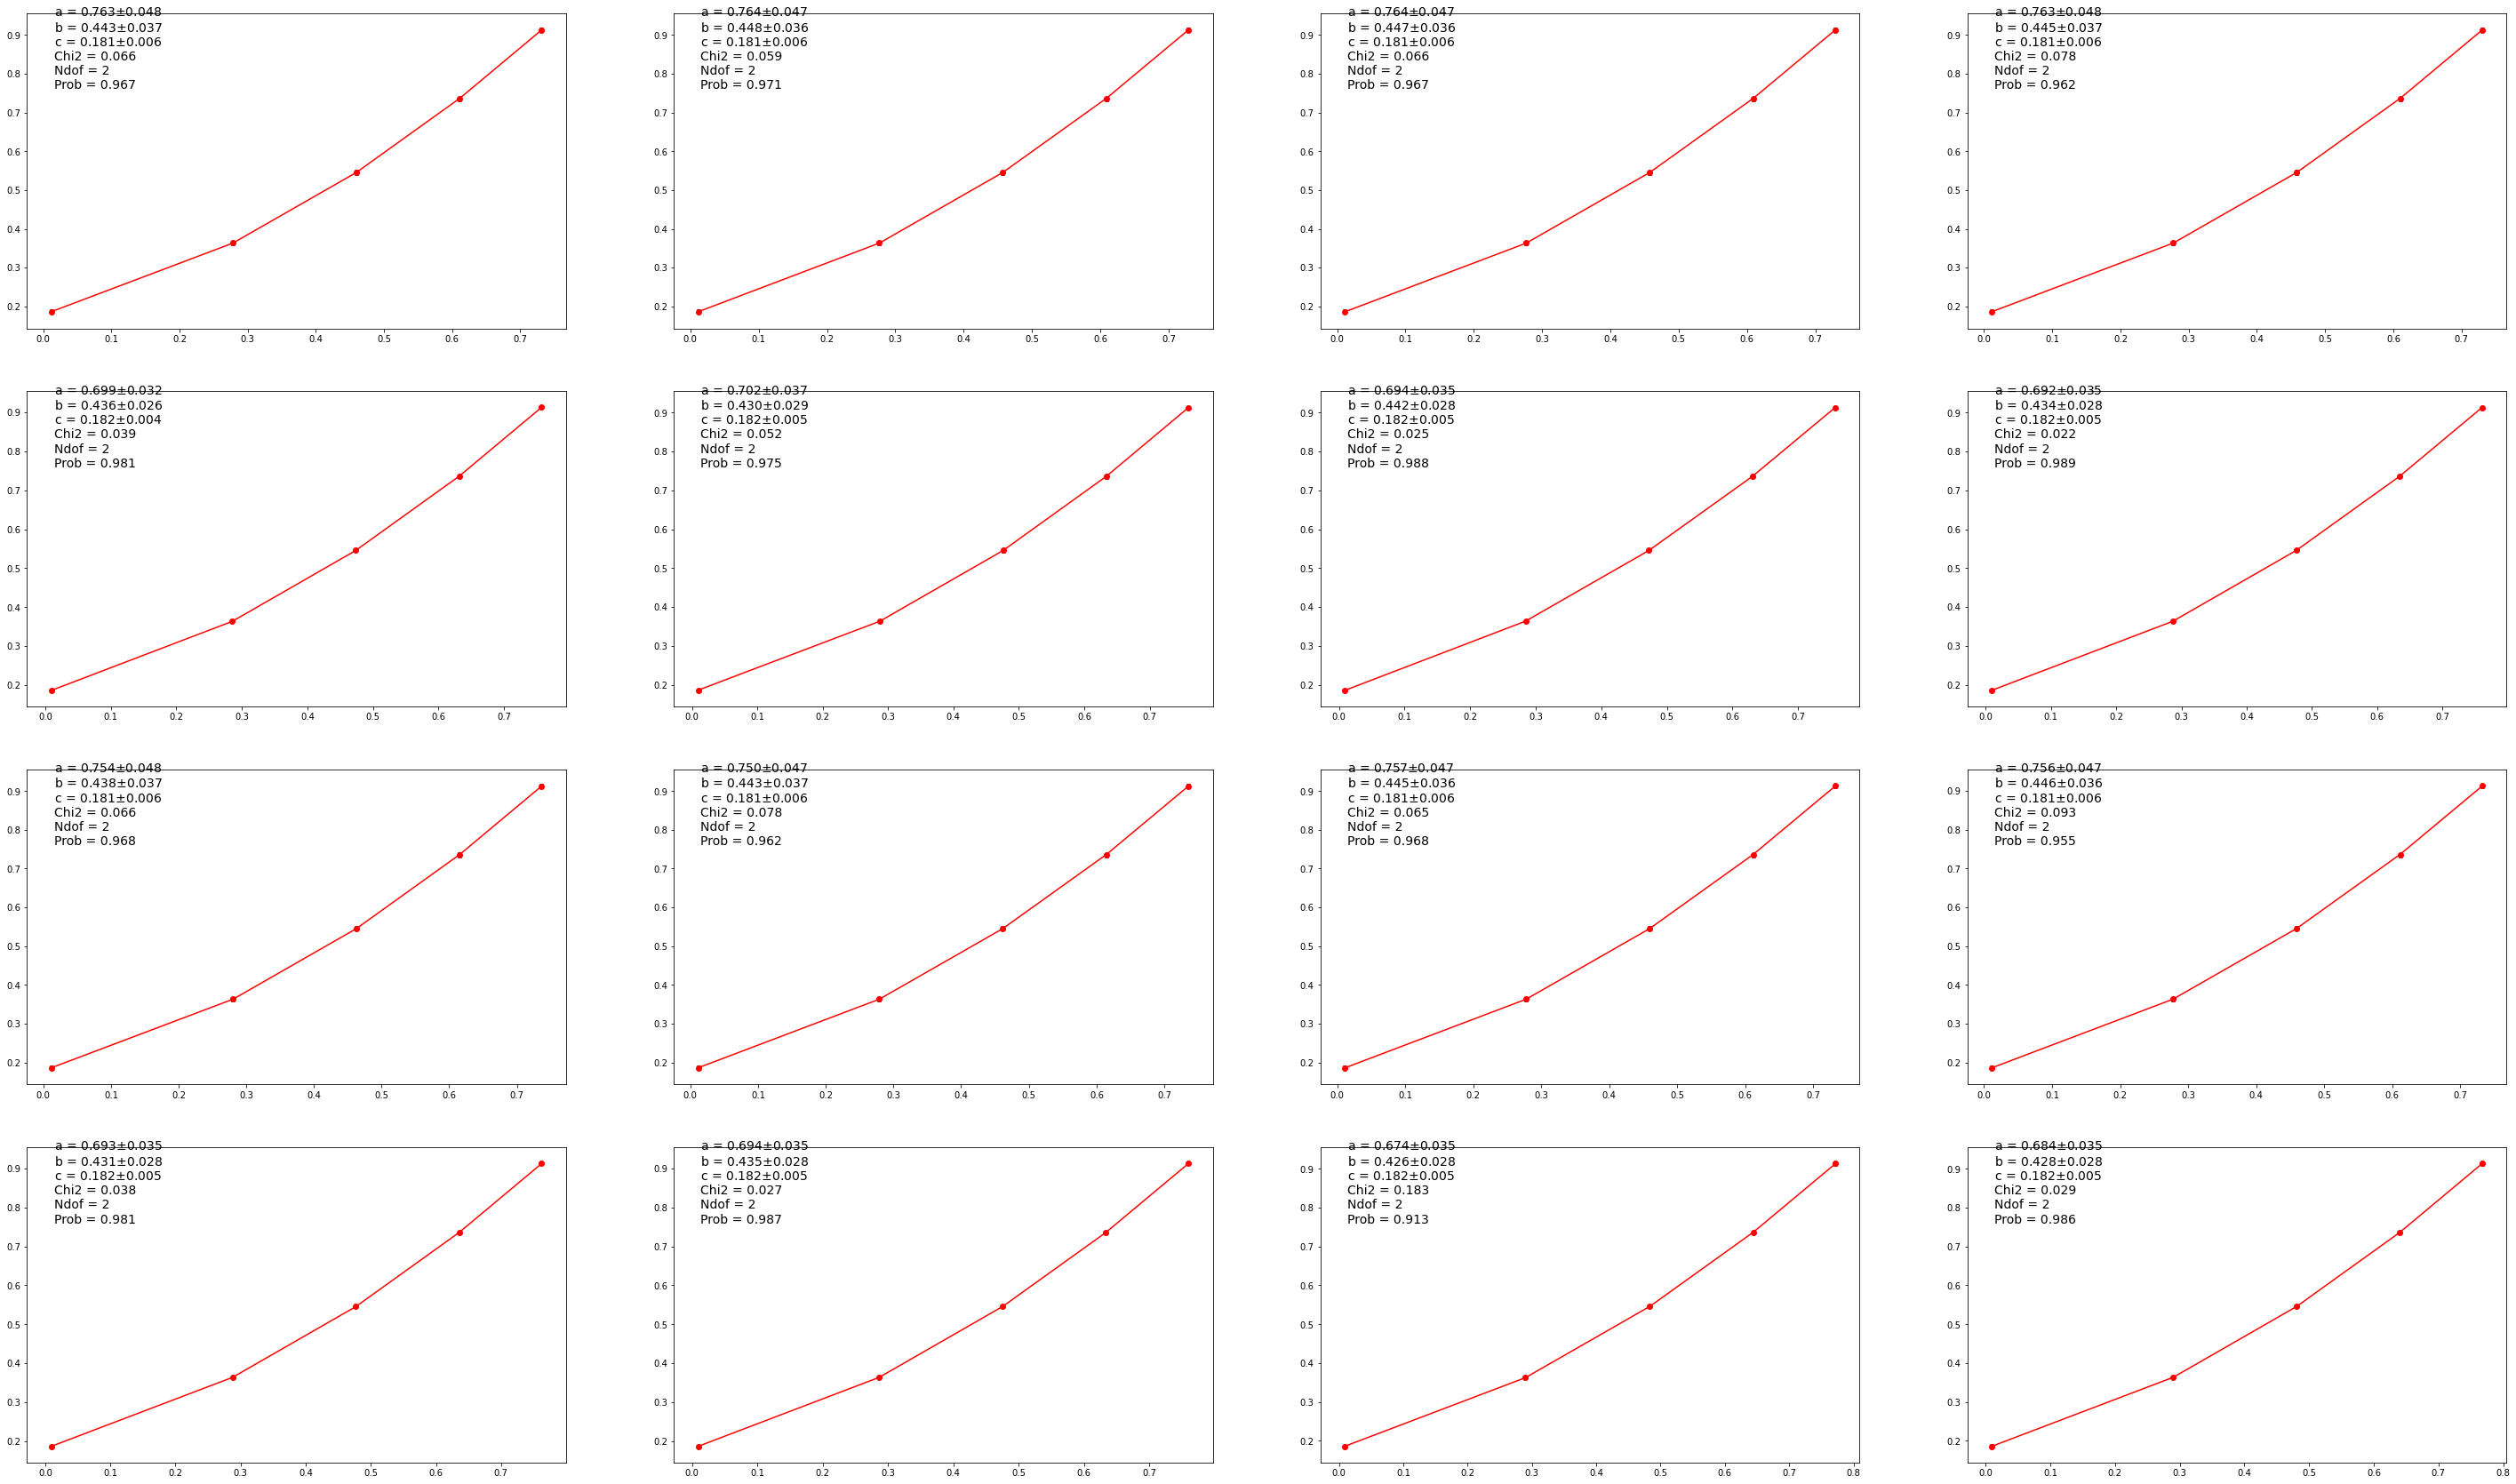

In [10]:
fig, axs = plt.subplots(4,4,figsize=(50,30))
axs = axs.flatten()
bold_weight= []
for i in files:
    bold_weight.append(bold_1 if '1_ball' in i else bold_2)
bold_weight = np.array(bold_weight)


final_a = np.zeros(16)
for i, data in enumerate(data_points):
    ax = axs[i]
    data_peaks = data[data[:,1] > 4.5]

    time_start = data_peaks[(np.abs(np.roll(data_peaks,1,axis=0)-data_peaks)[:,0]) > 0.01][:,0]
    time_stop =data_peaks[(np.abs(np.roll(data_peaks,-1,axis=0)-data_peaks)[:,0]) > 0.01][:,0]

    t  =  (time_start + (time_stop - time_start)/2 - time_start[0])[:5]
    
 

    a, b, c = 9.82, 0, 0
    sigmay = np.std(time_start- time_stop)

    x = np.array(t)

    y = samlet_afstand
    sy = sigmay * np.ones_like(x)

    def fit_func(x, a, b, c): 
        return a*x**2 + b*x + c

    chi2 = LeastSquares(x,y,sy,fit_func)

    def chi2_func( a, b, c):
        return np.sum(((y - fit_func(x, a, b, c)) / sy)**2)

    mfit = Minuit(chi2_func,a=a,b=b, c=c)

    mfit.migrad()

    a_fit = mfit.values['a']
    b_fit = mfit.values['b']
    c_fit = mfit.values['c']
    sigma_c_fit = mfit.errors['c']
    sigma_a_fit = mfit.errors['a']
    sigma_b_fit = mfit.errors['b']
    final_a[i] = a_fit
    Nvar = 3                   
    Ndof_fit = len(t) - Nvar

    Chi2_fit = mfit.fval                            
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)
    
    print(f"fit: a={a_fit:6.3f}+-{sigma_a_fit:5.3f}  b={b_fit:5.3f}+-{sigma_b_fit:5.3f}  c={c_fit:5.3f}+-{sigma_c_fit:5.3f}  p={Prob_fit:6.4f}")
    ax.errorbar(x, y, sy, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
    ax.plot(x, fit_func(x, *mfit.values[:]), '-r')      

    fit_info = [f'a = {a_fit:5.3f}' + r'$\pm$' +  f"{sigma_a_fit:5.3f}",
                f'b = {b_fit:5.3f}' + r'$\pm$' + f"{sigma_b_fit:5.3f}",
                f'c = {c_fit:5.3f}' + r'$\pm$' + f"{sigma_c_fit:5.3f}",
                f'Chi2 = {Chi2_fit:5.3f}',
                f'Ndof = {Ndof_fit:d}',
                f'Prob = {Prob_fit:5.3f}',
    ]

    ax.text(0.05, 0.76, "\n".join(fit_info), fontsize=14, transform = ax.transAxes)



In [11]:
rail_tyk = (3 + 2.9 + 3 + 3) / 400 

#regnet vinkel 
a = (22.2 + 22+ 22.2 + 22.3 - 4*rail_tyk) / 400
c = (93.45 + 93.65 + 93.5 + 93.6) / 400
b = np.sqrt(c**2 - a**2)
print(b)

theta2 = np.arcsin(b / c)
print(theta2*180 / np.pi)

0.9089109088594713
76.30690814368934


In [12]:
a_1 = final_a *2
theta = np.deg2rad(90-samlet_vinkel)
g = (a_1 / np.sin(theta)) * (1+(2/5)*(bold_weight**2) / (bold_weight**2 - d_r_inder**2))
print(a_1)



[1.52647019 1.52749639 1.52700913 1.52659213 1.39851553 1.40392744
 1.38763158 1.38369726 1.50892666 1.50032732 1.51344556 1.51191112
 1.38548266 1.3888786  1.34827113 1.36828171]
